In [ ]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **1. Downloading the Dataset:**
Sentiment140 dataset consisting of 1.6M tweets retrieved using twitter API has been used for this project.
<br><br>**Link:** https://www.kaggle.com/datasets/kazanova/sentiment140
<br>**Dataset Name:** training.1600000.processed.noemoticon.csv

In [ ]:
# Importing the dataset
columns = ['target','ids','date','flag','user','text']
df = pd.read_csv('tweets.csv', encoding='ISO-8859-1', names=columns)
df.sample(5)

,target,ids,date,flag,user,text
661276,0,2243072577,Fri Jun 19 12:59:30 PDT 2009,NO_QUERY,deansaliba,@willzilla1978 http://twitpic.com/7tawt - A li...
457353,0,2071556574,Sun Jun 07 19:35:10 PDT 2009,NO_QUERY,MrsRiccardelli,Sunday night already..... work on Monday
1059535,4,1963223135,Fri May 29 12:23:44 PDT 2009,NO_QUERY,sabinagl,"@FUCKCITY hey andy, my mom wants fob to play a..."
1041566,4,1957089907,Thu May 28 23:29:26 PDT 2009,NO_QUERY,poinktoinkdoink,@ohmygoshnina I know na how
392896,0,2055258209,Sat Jun 06 08:59:40 PDT 2009,NO_QUERY,robtyrie,@forshannonski sorry to hear about your Grandm...


## **2. Performing Exploratory Data Analysis (EDA):**

In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.nunique()

target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

In [ ]:
df.drop(['ids','date','flag','user'], axis=1, inplace=True)
df.sample(5)

,target,text
1397112,4,"@radiocd oh crap, it's always the little thing..."
593623,0,Some one stole it...and powered it off...I fee...
735887,0,full off fishcake ooooooooooooochhhh
115516,0,I realized that ever since I got back home fro...
1266795,4,@officialkathyg right on hehe


In [ ]:
df.shape

(1600000, 2)

In [ ]:
df["target"].unique()

array([0, 4])

In [ ]:
df["target"] = df['target'].replace(4,1)
df["target"].unique()

array([0, 1])

In [ ]:
target_counts = df['target'].value_counts()

positive_tweets = target_counts[1]
negative_tweets = target_counts[0]

print(f'Positive Tweets: {positive_tweets} \nNegative Tweets: {negative_tweets}')

Positive Tweets: 800000 
Negative Tweets: 800000


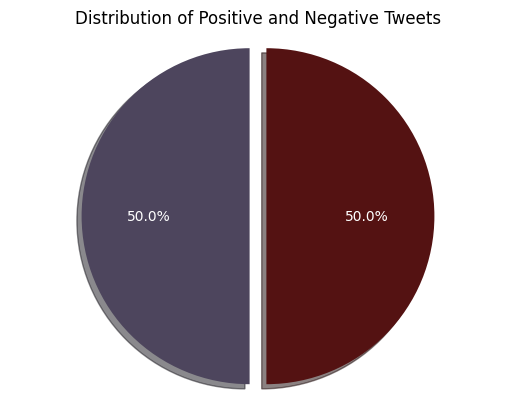

In [ ]:
labels = ['Positive', 'Negative']
sizes = [positive_tweets, negative_tweets]
colors = ['#4D455D', '#541212']
explode = (0.1, 0)  # Explode the Positive slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'color': 'white'})
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

plt.title('Distribution of Positive and Negative Tweets')
plt.show()

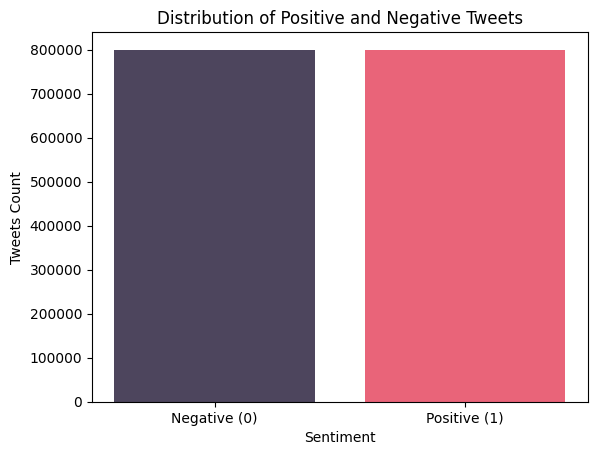

In [ ]:
labels = ['Negative (0)', 'Positive (1)']
counts = [negative_tweets, positive_tweets]
colors = ['#4D455D', '#E96479']

plt.bar(labels, counts, color=colors)

plt.xlabel('Sentiment')
plt.ylabel('Tweets Count')
plt.title('Distribution of Positive and Negative Tweets')

plt.show()

In [ ]:
from sklearn.utils import shuffle

dataset = df.copy()
dataset = shuffle(dataset)
dataset.sample(5)

,target,text
719436,0,PPPPOOOOOOOPPPPPP!!!! i'm no longer allowed to...
1131492,1,"@deppisch we still love you, honey. *muah*"
581263,0,@Placepot it says image not found
1001633,1,@toothwempale That sounds lovely. I had no id...
192002,0,worried about my marley


In [ ]:
dataset.shape

(1600000, 2)

## **3. Data Preprocessing:**##

`text_preprocessing` function has been created which is used for following tasks

*   Making all the tweets lowercase
*   Replacing all urls with ' '
*   Replacing all twitter handles (@someone) with ' '
*   Replacing all special characters with ' '
*   Replacing 3 or more consecutive letters with 3 (oooooh to ooh)
*   Removing stop words from tweets (the, she..)
*   Removing words of length less than 2
*   Lemmatizing the words (hours to hour)


In [ ]:
def text_preprocessing(text):
    processed_tweets = []

    # Defining stopwords list
    stopwords_list = set(stopwords.words('english'))

    # Creating lemmatizer
    lm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[\w]*'
    alphabetPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in text:
        tweet = tweet.lower()

        tweet = re.sub(urlPattern, ' ', tweet)
        tweet = re.sub(userPattern, ' ', tweet)
        tweet = re.sub(alphabetPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if word not in stopwords_list and len(word) > 1:
                word = lm.lemmatize(word)
                tweetwords += (word+' ')
        
        processed_tweets.append(tweetwords)

    return processed_tweets


In [ ]:
dataset["text"] = text_preprocessing(dataset["text"])
dataset.sample(5)

,target,text
311018,0,sound like dilema
593671,0,boyfriend fought feel sick
165883,0,super hungry waiting biotch feed
1112008,1,wanna go see versa emerge tonight im outt back...
1290996,1,yay first session


In [ ]:
dataset = dataset[dataset["text"].apply(len) > 0]
dataset.shape

(1591732, 2)

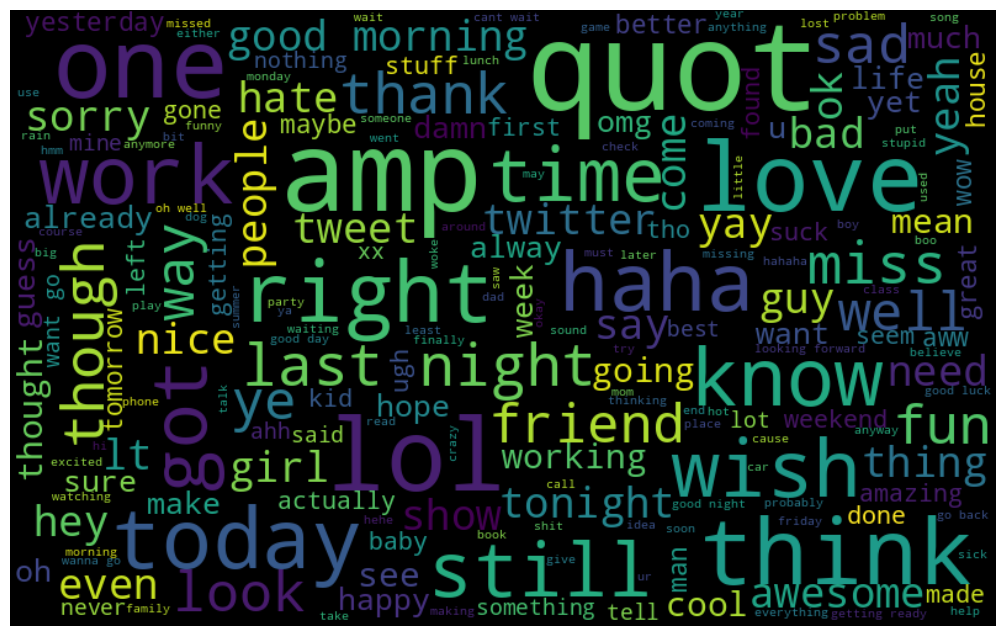

In [ ]:
# Creating Word Cloud for all tweets

all_words = ' '.join(dataset['text'])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

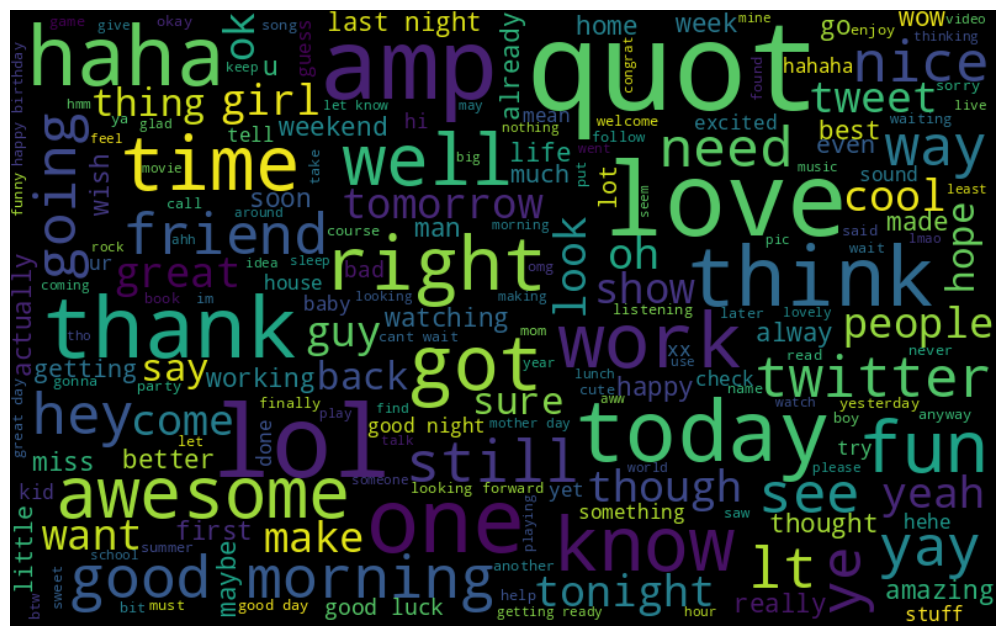

In [ ]:
# Creating Word Cloud for all positive tweets

text_pos = dataset.loc[dataset['target'] == 1, 'text']
all_pos_words = ' '.join(text_pos)

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_pos_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

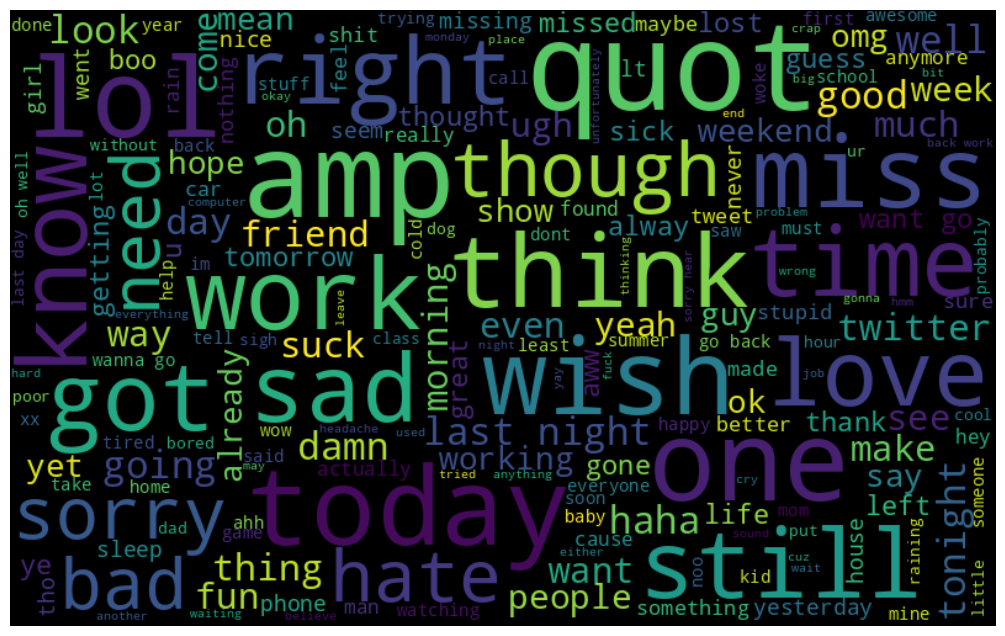

In [ ]:
# Creating Word Cloud for all negative tweets

text_neg = dataset.loc[dataset['target'] == 0, 'text']
all_neg_words = ' '.join(text_neg)

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_neg_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **4. Splitting Dataset into Train and Test:**

In [ ]:
# Splitting the dataset into features and target

X = dataset["text"]
y = dataset["target"]

In [ ]:
# Spliting dataset into Train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **5. Feature Extraction using `TfidfVectorizer` :**

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000, stop_words='english')

vectorizer.fit_transform(X_train)
print('No. of feature_words:', len(vectorizer.get_feature_names_out()))

No. of feature_words: 500000


In [ ]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

## **6. Model Training and Evaluation :**

Evalution metrics used:


*   Precision
*   Recall
*   F1 Score
*   Confusion Matrix



In [ ]:
def evaluate_model(model):
    
    y_pred = model.predict(X_test)

    print("*****************************************\nCLASSIFICATION REPORT\n*****************************************")
    print(classification_report(y_test, y_pred))
    

    print("\n*****************************************\nCONFUSION MATRIX\n*****************************************")
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

*****************************************
CLASSIFICATION REPORT
*****************************************
              precision    recall  f1-score   support

           0       0.79      0.77      0.78    159102
           1       0.77      0.80      0.79    159245

    accuracy                           0.78    318347
   macro avg       0.78      0.78      0.78    318347
weighted avg       0.78      0.78      0.78    318347


*****************************************
CONFUSION MATRIX
*****************************************


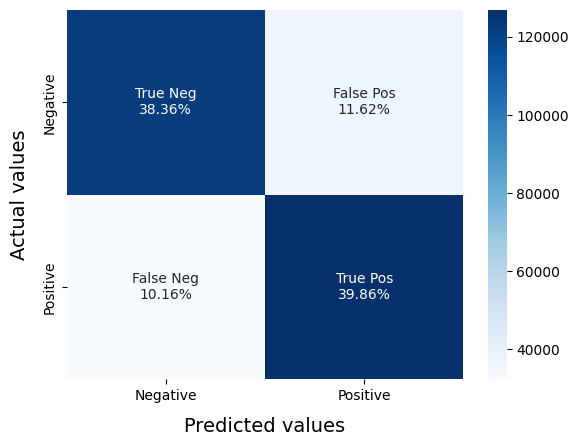

In [ ]:
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lr.fit(X_train, y_train)
evaluate_model(lr)

## **7. Prediction:**

In [ ]:
def predict(vectoriser, model, text):

    textdata = vectoriser.transform(text_preprocessing(text))
    target = model.predict(textdata)
    
    data = []
    for text, pred in zip(text, target):
        data.append((text, pred))
        
    df = pd.DataFrame(data, columns = ['text','target'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [ ]:
test_tweets = ["I hate twitter",
        "May the Force be with you.",
        "Mr Elon, I love this bird app!!"]

df_test = predict(vectorizer, lr, test_tweets)
print(df_test.head())

                              text    target
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr Elon, I love this bird app!!  Positive


## **8. Future Work:**

This project serves as a introductory guide to performing sentiment analysis using NLTK. However, there is ample room for improvement. A few suggestions include:
<br>
### **Experiment with Multiple Models:** 
Besides logistic regression, we can test other machine learning and deep learning models for sentiment analysis. Some examples include:

* Support Vector Machines (e.g linearSVC)
* Naive Bayes (e.g BernoulliNB)
* Random Forest
* Convolutional Neural Networks (CNN)

etc.
<br>
### **Hyperparameter Tuning:** 
We can optimize the performance of the selected models by performing hyperparameter tuning. Adjusting the hyperparameters can greatly impact the model's accuracy and generalization. We can use techniques such as `grid search` or `random search` to find the optimal combination of hyperparameters.

